In [10]:
import sys
sys.path.append("..")
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
cmap = plt.cm.tab20
from src.score_card import ScoreCardBuilder
from src.preprocess import Binner
import pickle

In [11]:
# with open("working-dir/model.pkl", "rb") as input_file:
#     model = pickle.load(input_file)

### Training the model

In [12]:
scorecard_builder = ScoreCardBuilder()

In [13]:
data = pd.read_csv("../dataset/germancredit.csv")

In [14]:
cols_num_beans = {
    "age.in.years":20, 
    "duration.in.month":10,
    "credit.amount":50

}
cols_todo_bins = list(cols_num_beans)
binner = Binner(cols_todo_bins, cols_num_beans)
selected_colums = data.columns[:-1]
binner.selected_columns = selected_colums
_ = binner(data)


In [15]:
binner.data.head()

,status.of.existing.checking.account,duration.in.month,credit.history,purpose,credit.amount,savings.account.and.bonds,present.employment.since,installment.rate.in.percentage.of.disposable.income,personal.status.and.sex,other.debtors.or.guarantors,...,property,age.in.years,other.installment.plans,housing,number.of.existing.credits.at.this.bank,job,number.of.people.being.liable.to.provide.maintenance.for,telephone,foreign.worker,creditability
0,... < 0 DM,"(3.932, 10.8]",critical account/ other credits existing (not ...,radio/television,"(976.96, 1340.44]",unknown/ no savings account,... >= 7 years,4,male : divorced/separated,none,...,real estate,"(66.6, 69.4]",none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes,good
1,0 <= ... < 200 DM,"(44.8, 51.6]",existing credits paid back duly till now,radio/television,"(5702.2, 6065.68]",... < 100 DM,1 <= ... < 4 years,2,male : divorced/separated,none,...,real estate,"(21.8, 24.6]",none,own,1,skilled employee / official,1,none,yes,bad
2,no checking account,"(10.8, 17.6]",critical account/ other credits existing (not ...,education,"(2067.4, 2430.88]",... < 100 DM,4 <= ... < 7 years,2,male : divorced/separated,none,...,real estate,"(47.0, 49.8]",none,own,1,unskilled - resident,2,none,yes,good
3,... < 0 DM,"(38.0, 44.8]",existing credits paid back duly till now,furniture/equipment,"(7519.6, 7883.08]",... < 100 DM,4 <= ... < 7 years,2,male : divorced/separated,guarantor,...,building society savings agreement/ life insur...,"(44.2, 47.0]",none,for free,1,skilled employee / official,2,none,yes,good
4,... < 0 DM,"(17.6, 24.4]",delay in paying off in the past,car (new),"(4611.76, 4975.24]",... < 100 DM,1 <= ... < 4 years,3,male : divorced/separated,none,...,unknown / no property,"(52.6, 55.4]",none,for free,2,skilled employee / official,2,none,yes,bad


In [16]:
def row_to_dict(row):
    output = {}
    for col in list(row.keys())[:-1]:
        output[col] = row[col]
    return output

In [17]:
scores = []
for index, row in binner.data.iterrows():
    features = row_to_dict(row)
    score = scorecard_builder.compute_score(features)
    scores.append(score)

In [18]:
binner.data["score"] = scores

In [19]:
binner.data[["creditability", "score"]].head(30)

,creditability,score
0,good,714.488219
1,bad,644.899378
2,good,743.863010
3,good,673.664860
4,bad,594.565752
5,good,679.463219
6,good,717.702956
7,good,636.279557
8,good,752.732890
9,bad,626.472932


In [20]:
good_min, good_max, bad_min, bad_max = [None] * 4

In [21]:
for index, row in binner.data.iterrows():
    if row["creditability"] == "good":
        if good_min is None or good_min > row["score"]:
            good_min = row["score"]
        if good_max is None or good_max < row["score"]:
            good_max = row["score"]
    else:
        if bad_min is None or bad_min > row["score"]:
            bad_min = row["score"]
        if bad_max is None or bad_max < row["score"]:
            bad_max = row["score"]

In [22]:
good_min

570.162982776487

In [23]:
good_max

1515.2529013586459

In [24]:
bad_min

-235.26000025216166

In [25]:
bad_max

746.1369090331581

In [26]:
ranges = [(i * 50, (i + 1) * 50) for i in range(20)]

In [27]:
range_counts = defaultdict(lambda: defaultdict(int))

In [28]:
for index, row in binner.data.iterrows():
    score = int(round(row['score']))
    if score % 50 == 0:
        range_min = (score // 50 - 1) * 50
        range_max = score
    else:
        range_min = score // 50  * 50
        range_max = (score//50 + 1) * 50
    c = row["creditability"]
    range_counts[c][(range_min, range_max)] += 1

In [29]:
range_counts

defaultdict(<function __main__.<lambda>()>,
            {'good': defaultdict(int,
                         {(700, 750): 243,
                          (650, 700): 280,
                          (600, 650): 115,
                          (750, 800): 47,
                          (550, 600): 11,
                          (1400, 1450): 2,
                          (1450, 1500): 1,
                          (1500, 1550): 1}),
             'bad': defaultdict(int,
                         {(600, 650): 155,
                          (550, 600): 47,
                          (-150, -100): 5,
                          (650, 700): 73,
                          (700, 750): 13,
                          (-200, -150): 3,
                          (-250, -200): 1,
                          (500, 550): 2,
                          (0, 50): 1})})

In [30]:
scorecard_builder.offset

647.1228762045055

In [31]:
scorecard_builder.factor

28.85390081777927

In [32]:
df1 = pd.DataFrame(range_counts["good"].items())
df2 = pd.DataFrame(range_counts["bad"].items())

In [33]:
# df1 = df1[[i  for i in ranges if i in df1.columns]]
# df2 = df2[[i  for i in ranges if i in df2.columns]]

In [34]:
df1

,0,1
0,"(700, 750)",243
1,"(650, 700)",280
2,"(600, 650)",115
3,"(750, 800)",47
4,"(550, 600)",11
5,"(1400, 1450)",2
6,"(1450, 1500)",1
7,"(1500, 1550)",1


<AxesSubplot:xlabel='0'>

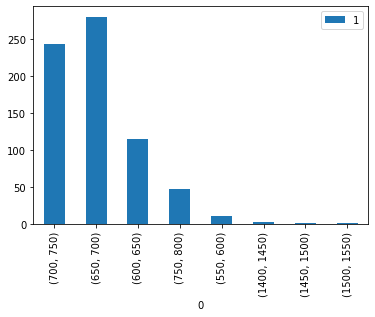

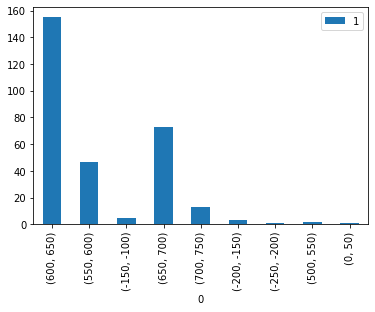

In [35]:
df1.plot.bar(x = 0, y=1)
df2.plot.bar(x = 0, y=1)

In [36]:
binner.data.columns

Index(['status.of.existing.checking.account', 'duration.in.month',
       'credit.history', 'purpose', 'credit.amount',
       'savings.account.and.bonds', 'present.employment.since',
       'installment.rate.in.percentage.of.disposable.income',
       'personal.status.and.sex', 'other.debtors.or.guarantors',
       'present.residence.since', 'property', 'age.in.years',
       'other.installment.plans', 'housing',
       'number.of.existing.credits.at.this.bank', 'job',
       'number.of.people.being.liable.to.provide.maintenance.for', 'telephone',
       'foreign.worker', 'creditability', 'score'],
      dtype='object')

In [37]:
binner.data['status.of.existing.checking.account'].unique()

array(['... < 0 DM', '0 <= ... < 200 DM', 'no checking account',
       '... >= 200 DM / salary assignments for at least 1 year'],
      dtype=object)

In [38]:
binner.data['duration.in.month'].unique()

[(3.932, 10.8], (44.8, 51.6], (10.8, 17.6], (38.0, 44.8], (17.6, 24.4], (31.2, 38.0], (24.4, 31.2], (58.4, 65.2], (51.6, 58.4], (65.2, 72.0]]
Categories (10, interval[float64]): [(3.932, 10.8] < (10.8, 17.6] < (17.6, 24.4] < (24.4, 31.2] ... (44.8, 51.6] < (51.6, 58.4] < (58.4, 65.2] < (65.2, 72.0]]